# Aprendizaje No Supervisado: Algoritmos de clustering

A diferencia de los algoritmos supervisados, donde tenemos un target que sería la evaluación de cada observación, en los algoritmos no supervisados no contamos con dicha variable, lo que significa que no podremos entrenar en base a los datos.

Dado que los algoritmos supervisados se basan en ajustar las variables predictoras a la variable target, es fácil deducir que en los problemas donde no exista esa variable target no podremos utilizar los algoritmos supervisados. De esa necesidad nacen los algoritmos no supervisados.

Existen dos grandes tipos de algoritmos no supervisados:

 * **Algoritmos de clusterización**: Algoritmos cuyo objetivo es agrupar las observaciones en grupos que tengan algún tipo de característica común. En este notebook, veremos el K-means y el DBSCAN.
 * **Algoritmos de reducción de la dimensionalidad**: En este caso el objetivo es alterar el eje de coordenadas de nuestros datos para comprimirla mayor cantidad de información posible en la menor cantidad de variables. En este caso, se trata de un concepto que ya hemos visto en clase por medio del PCA, que repasaremos en futuros notebooks.

## Algoritmos de clusterización

Todos los algoritmos de clusterización tienen algo en común: su objetivo es agrupar los puntos que más se parecen entre sí. Será en la definición de esos *parecen* y *entre sí* lo que les haga diferentes.

### K-means
Pasos a seguir:
1. Inicializamos k centroides de manera aleatoria, donde k es un número elegido de antemano (habrá que probar diferentes valores si no conocemos lo que tenemos que predecir)
2. Calculamos para cada punto, qué centroide esta más cerca
3. Cuando se ha calculado esa asociación punto-centroide, recalculamos la situación de los centroides, siendo ahora la posición media de todos los puntos asignados a ellos en el paso 2.
4. Repetimos los pasos 2-3 hasta que se estabilice (ningún punto cambie de centroide)

Y con este procedimiento llegaremos a una división de los datos en k grupos diferentes. Sin embargo, ¿cómo podemos calcular este k?

##### Encontrar el K óptimo

Tenemos 2 formas principales de encontrar ese k óptimo del que hablamos:
1. **Intertia + elbow**: Inertia nos suma la distancia de cada punto a su centroide. Como esta suma siempre va a ser menor cada vez que se amplíe la k, por sí sola no podemos sacar información de qué k es mejor. Sin embargo, sí que podemos guiarnos por la técnica de *elbow* (codo en inglés), que se basa en escoger la k donde la gráfica de inertias para cada k dibuja un codo, es decir, donde la mejora de inertia de un k al siguiente se reduce mucho, pasando a algo prácticamente lineal (lo veremos con una imagen).

2. **Silhouette score**: Esta técnica, al contrario de la anterior, no se trata de algo gráfico sino que nos dará una métrica numérica para poder evaluar el número k elegido.

##### Evaluación de k-means

Además de no buscar automáticamente un valor bueno de k, el algoritmo K-means tiene un problema muy importante: es muy sensible a la inicialización de los centroides, y diferentes inicializaciones no tienen porqué converger en un mismo resultado, por lo que conviene poder evaluar los modelos para saber qué inicialización es mejor. En este caso, la inertia sí que nos puede ser de utilidad, ya que estamos comparando diferentes modelos, pero todos ellos con la misma cantidad de centroides.

Problemas del K-means:
 * Es sensible a la inicialización aleatoria de los centroides
 * Sensible a outliers
 * Hay que definir de antemano la cantidad de clusters que queremos
 * Al basarse en distancias euclídeas, podemos tener problemas si no tenemos los datos normalizados, o cuando crezcan mucho las dimensiones de nuestro problema.
 
A continuación, tienes un enlace a una web donde puedes jugar gráficamente con este algoritmo:
[Visualización del K-means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)


### DBSCAN

Una vez visto el algoritmo K-Means, pasemos a otro algoritmo no supervisado que trata de corregir alguno de los errores del K-Means: el algoritmo DBSCAN.

Pasos a seguir:

1. Definimos **epsilon** (distancia desde un punto para considerarlo vecino) y **minPoints** (número mínimo de vecinos para considerar a un punto núcleo)
2. Buscamos todos los vecinos para todos los puntos, y los puntos que tengan más vecinos que **minPoints** lo marcamos como núcleo.
3. Cada punto núcleo y todos sus vecinos lo asignamos a un cluster, si no está asignado previamente a ninguno. Recursivamente, vamos añadiendo a sus vecinos núcleo.

De esta forma, DBSCAN da solución a los problemas que nos encontramos en el K-means, aunque también tiene sus propios problemas. El principal de ellos es que, así como el K-Means depende de cuántos k le hayan definido, DBSCAN es bastante sensible a la inicialización del epsilon y los minPoints.

A continuación, tienes un enlace a una web donde puedes jugar gráficamente con este algoritmo:
[Visualización del DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)


## Pasando a la práctica


Una vez entendida la parte más teórica, pasemos a la práctica. En este notebook vamos a ver los 2 principales algoritmos de clustering: KMeans y DBSCAN.

Comenzaremos estudiando la diferencia entre los algoritmos de clasificación y clustering, que nos ayudará a diferenciar los algoritmos supervisados, que hemos visto anteriormente, de los no supervisados, que vamos a estudiar ahora.

Tras ello, nos meteremos a definir qué es KMeans y cuál es el proceso que seguiremos para crear los clusters. Después estudiaremos los métodos para calcular el mejor número de clusters y cómo evaluarlo. Finalmente, veremos el algoritmo DBSCAN, que introduce un mecanismo diferente para calcular los centroides y el número de clusters.

Para empezar, configuraremos el entorno importando las librerías:

In [15]:
import sys
import sklearn
import numpy as np
import os
# Configuramos la semilla
np.random.seed(42)

# Para pintar:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Y nuestra función para guardar imágenes:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Clustering

### Introducción: Clasificación vs Clustering

Lo primero que debemos aclarar es la diferencia entre algoritmos de clasificación y algoritmos de clustering. Si bien es cierto que los algoritmos de clustering los utilizamos para identificar grupos o clases dentro de un dataset, al igual que hacíamos con los algoritmos de clasificación, la forma de hacerlo cambia radicalmente.

En el caso de clasificación estamos hablando de algoritmos supervisados, donde conocemos la variable objetivo (target), y nuestro objetivo es extraer los patrones de los datos que gobiernan esa variable que queremos predecir. Sin embargo, en el caso de los algoritmos no supervisados no tenemos esa variable para utilizarla de referencia, por lo que la cosa se complica. En este caso, lo que tenemos que hacer es identificar grupos en base únicamente a las variables predictoras, es decir, a las columnas de nuestra matriz X (pues no existe y).

¿Y cómo hacemos eso? Pues aquí entran los algoritmos que vamos a ver: KMeans y DBSCAN.

Vamos a comenzar cargando los famosos datos de las flores Iris:

In [16]:
from sklearn.datasets import load_iris

In [17]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Pintaremos los 2 casos que hemos comentado anteriormente para entender la diferencia: una donde tenemos identificada la clase (supervisado) frente a otra donde solo tenemos la distribución de los datos (no supervisado):

Saving figure classification_vs_clustering_plot


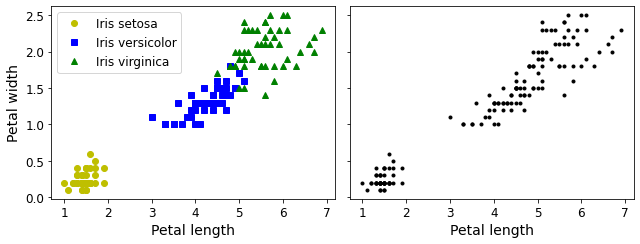

In [19]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

En el caso de la izquierda ya hemos visto cómo actuar, sin embargo, ¿cómo lo hacemos en el de la derecha?

Pues podemos analizar las relaciones entre los datos para obtener diferentes grupos. Por defecto, no sabremos cuántos grupos de datos existen, por lo que tendremos que ir probando. En este caso, vamos a hacer un poco de trampa y vamos a suponer que son 3 grupos diferentes. Veamos cómo identificaría el algoritmo estos 3 grupos (no te preocupes, ya veremos cómo funciona el algoritmo un poco más adelante):

In [20]:
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=101)
y_pred = kmeans.fit_predict(X)

mapping = np.array([1, 0, 2])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

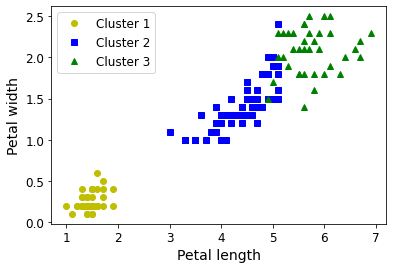

In [21]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

Como puedes comprobar, la mayoría de los datos se han clasificado correctamente. Veamos alguna métrica sencilla:

In [22]:
np.sum(y_pred==y)

134

In [23]:
np.sum(y_pred==y) / len(y_pred)

0.8933333333333333

## K-Means

Una vez entendida la diferencia entre clasificación y clustering, podemos pasar a ver cómo funciona este algoritmo.

Para empezar, generaremos unos "blobs" (grupos de puntos aleatorios), que estarán caracterizados por un centroide (el centro del blob) y su dispersión:

In [24]:
from sklearn.datasets import make_blobs

In [25]:
# Definimos los centroides de nuestros datos sintéticos y su dispersión:
blob_centroides = np.array([[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [26]:
X, y = make_blobs(n_samples = 2000, centers = blob_centroides, cluster_std = blob_std, random_state = 7)

In [27]:
X

array([[-2.69823941,  1.3454702 ],
       [-2.87459835,  1.8097575 ],
       [ 0.96077126,  1.17046777],
       ...,
       [-2.80303543,  2.72948115],
       [ 0.24057359,  2.40103109],
       [-2.63807768,  1.95621065]])

Ahora, algo que vamos a agradecer para entender esto: vamos a pintar:

In [28]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


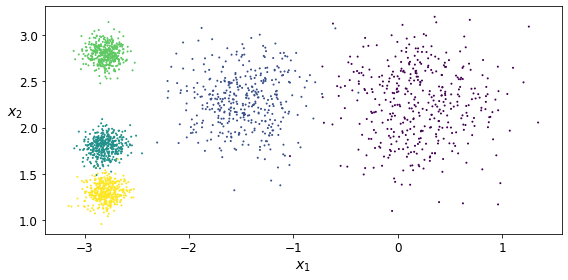

In [29]:
plt.figure(figsize=(8, 4))
plot_clusters(X, y)
save_fig("blobs_plot")
plt.show()

Como puedes observar, lo que hemos creado es una figura con varios grupos de puntos repartidos de forma aleatoria con unos centros determinados.

### Entrenamiento y Predicción

Para utilizar el algoritmo KMeans, que es el primero que veremos, haremos igual que hemos hecho con el resto de algoritmos supervisados, solo que en lugar de pasarle como parámetros ``X`` e ``y``, solo le pasaremos ``X``. Además, el algoritmo KMeans tiene la particularidad de que necesita un parámetro ``k`` que le indique el número de clusters que va a buscar, ya que no tiene la capcidad de encontrar un valor óptimo por sí solo (veremos un par de métricas).

Veamos un ejemplo de cómo entrenar y predecir con un algoritmo KMeans, con ``k=5`` clusters:

In [32]:
from sklearn.cluster import KMeans

In [33]:
k = 5
kmeans = KMeans(n_clusters = k, random_state = 42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

Una vez entrenado el modelo, podemos obtener los centroides de los clusters que hemos calculado:

In [34]:
kmeans.cluster_centers_

array([[-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

Cada centroide representa un grupo (cluster) al que asociaremos cada uno de los puntos. La etiqueta que les pondremos hará referencia al índice del centroide que acabamos de ver:

In [35]:
kmeans.labels_

array([0, 4, 1, ..., 2, 1, 4])

Como puedes observar, las salidas del algoritmo se parecen a las de un problema supervisado de clasificación con un número de clases igual al número de clusters (``k``).

También lo podemos comprobar al realizar predicciones:

In [36]:
print(kmeans.predict([[2,3], [-3, 1], [-10, 10]]))

[1 0 2]


Una vez hemos entrenado, haremos predicciones sobre los datos que hemos analizado, pues en este caso no habrá train y test, sino que solo tendremos unos datos sobre los que extraer conclusiones sin ningún tipo de referencia:

In [37]:
y_pred = kmeans.predict(X)
y_pred

array([0, 4, 1, ..., 2, 1, 4])

Si aplicamos un color diferente a cada cluster que hemos predicho, nos quedaría la siguiente imagen:

Saving figure blobs_plot


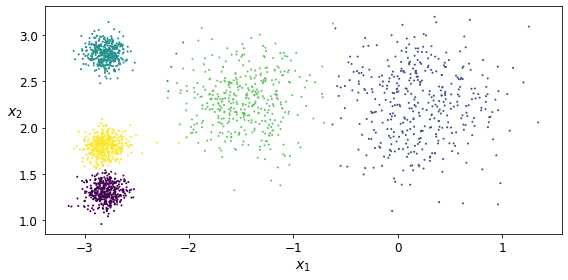

In [38]:
plt.figure(figsize=(8, 4))
plot_clusters(X, y = kmeans.predict(X))
save_fig("blobs_plot")
plt.show()

No está nada mal. Algunos puntos cercanos a los bordes de decisión se habrán categorizado en un cluster de forma errónea, pero a grandes rasgos parece que está bien.

¿Y cómo vemos los bordes de decisión? A continuación, veremos un ejemplo para que quede bien claro.

### Bordes de decisión

Tras obtener los centroides, resulta interesante analizar los bordes de decisión de nuestro algoritmo, para lo que vamos a utilizar ciertas funciones definidas específicamente para esto (no hay que saberlo):

In [39]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


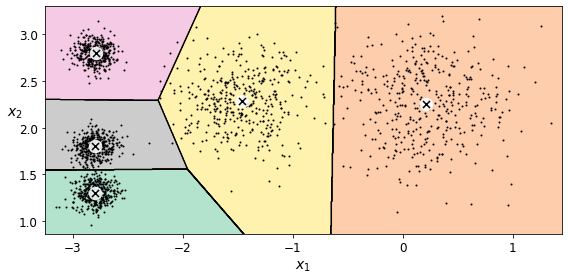

In [42]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

En la imagen podemos observar los centroides de cada cluster que hemos identificado, así como los bordes de decisión entre diferentes clusters.

### Hard Clustering _vs_ Soft Clustering

En lugar de elegir arbitrariamente el clúster más cercano para cada instancia, método llamado _hard clustering_, sería mejor medir la distancia de cada punto a los 5 centroides. Esto es lo que hace el método ``transform()``:

In [43]:
X_new = np.array([[-0.5, 0], [0, 0.5], [-2, 8], [2, 1]])

In [44]:
kmeans.transform(X_new)

array([[2.64270299, 2.36425159, 3.6162573 , 2.48189856, 2.92441223],
       [2.91263281, 1.76788268, 3.6157723 , 2.31100907, 3.09110062],
       [6.74681697, 6.15449112, 5.2636525 , 5.73897004, 6.25072944],
       [4.80979312, 2.18742854, 5.11849694, 3.69757936, 4.87024719]])

In [45]:
kmeans.predict(X_new)

array([1, 1, 2, 1])

Podemos verificar que esta es la distancia Euclídea entre el punto y cada centroide:

In [46]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.64270299, 2.36425159, 3.6162573 , 2.48189856, 2.92441223],
       [2.91263281, 1.76788268, 3.6157723 , 2.31100907, 3.09110062],
       [6.74681697, 6.15449112, 5.2636525 , 5.73897004, 6.25072944],
       [4.80979312, 2.18742854, 5.11849694, 3.69757936, 4.87024719]])

### Funcionamiento del K-Means

El algoritmo KMeans es uno de los algoritmos más rápidos, pero también de los más simples:

* En primer lugar, se inicializan los ``k`` centroides de manera aleatoria: se eligen ``k`` puntos diferentes del dataset con aleatoriedad y ahí se ubican los centroides.

* Se calcula a qué centroide pertenece cada punto en base a su posición
* Se recalcula la posición del centroide, situándose ahora en la posición media de todos los puntos asignados en el paso anterior
* Se repiten los 2 pasos anteriores hasta que se estabilice (ningún punto cambie de centroide)

El KMeans aplica un algoritmo optimizado por defecto. Para obtener el algoritmo original de KMeans, deberíamos poner los siguientes parámetros: `init="random"`, `n_init=1` y `algorithm="full"`.

Veamos cómo se mueven los centroides en sucesivas iteraciones (3):

In [47]:
kmeans_iter1 = KMeans(n_clusters = 5, init = 'random', n_init = 1, algorithm = 'full', max_iter = 1, random_state = 1)
kmeans_iter2 = KMeans(n_clusters = 5, init = 'random', n_init = 1, algorithm = 'full', max_iter = 2, random_state = 1)
kmeans_iter3 = KMeans(n_clusters = 5, init = 'random', n_init = 1, algorithm = 'full', max_iter = 3, random_state = 1)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

Saving figure kmeans_algorithm_plot


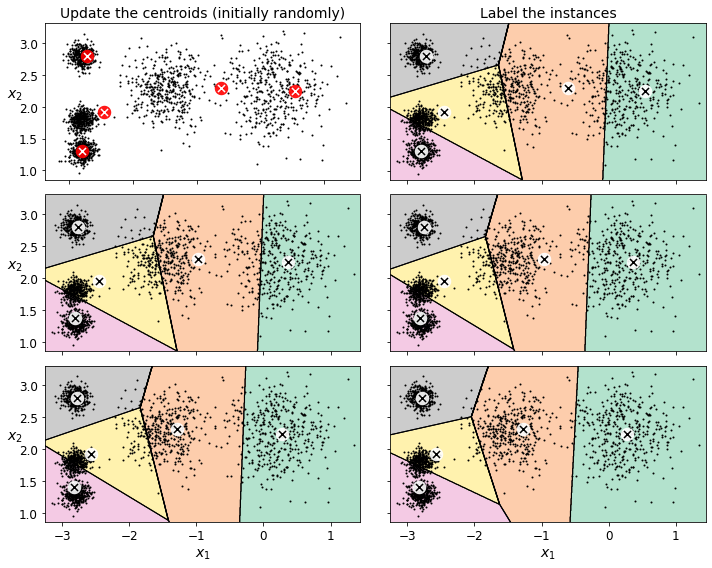

In [48]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

### Variabilidad del K-Means

En el algoritmo original KMeans, los centroides se inicializaban aleatoriamente, y el algoritmo los recalculaba iteración a iteración para mejorar la posición de los centroides, como hemos visto arriba.

Sin embargo, nuestro mayor problema con esto es que si corremos el algoritmo KMeans muchas veces (o con diferentes semillas), puede converger a muy variadas soluciones, como veremos a continuación:

In [49]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


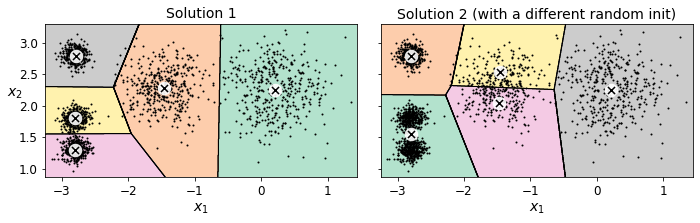

In [51]:
kmeans_rnd_init1 = KMeans(n_clusters = 5, init = 'random', n_init = 1, algorithm = 'full', random_state = 1)
kmeans_rnd_init2 = KMeans(n_clusters = 5, init = 'random', n_init = 1, algorithm = 'full', random_state = 29)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

Como puedes observar, los resultados son drásticamente diferentes. Visualmente, diríamos que la opción más correcta sería la de la izquierda, pero vamos a ver qué podemos utilizar para seleccionar el mejor modelo:

### Inertia

Para seleccionar el mejor modelo, necesitaremos establecer un método para evaluar el _performance_ del modelo KMeans. Lamentablemente, el clustering es una tarea no supervisada, es decir, que no tenemos target. Sin embargo, sí que podemos medir las distanias de cada punto a su centroide. Pues esa es la idea detrás de la métrica _inertia_.

Comprobemos esta métrica para cada uno de los 2 modelos:

In [52]:
kmeans_rnd_init1.inertia_

211.5998851766949

In [53]:
kmeans_rnd_init2.inertia_

238.7800911394769

Como puedes comprobar, _inertia_ es la suma de los cuadrados de las distancias entre los puntos de training y su centroide más cercano. Hagamos la comprobación para el ``kmeans_rnd_init1``:

In [54]:
X_dist = kmeans.transform(X)
X_dist[np.arange(len(X_dist)), kmeans.labels_]**2

array([0.0124251 , 0.00507237, 1.74284027, ..., 0.00458222, 0.02218732,
       0.05153027])

In [55]:
sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816785

Por otra parte, el método ``score()`` devuelve su valor pero de forma negativa, lo cual se corresponde con lo que veíamos en otros métodos con su scoring, como el GridSearchCV, donde se usaba la métrica ``neg_log_loss``, ya que se encargan de maximizar el valor, que en este caso seria bajarlo a 0.

In [56]:
kmeans.score(X)

-211.5985372581683

### Múltiples inicializaciones

Así que una posible solución del problema de variabilidad consiste, simplemente, en ejecutar el algoritmo K-Means varias veces con diferentes inicializaciones aleatorias, seleccionando la solución que minimiza el score _inertia_. Por ejemplo, aquí están las inertias de los dos últimos modelos que hemos inicializado de forma aleatoria:

In [57]:
kmeans_rnd_init1.inertia_

211.5998851766949

In [58]:
kmeans_rnd_init2.inertia_

238.7800911394769

Cuando seleccionamos el parámetro ``n_init``, Scikit-Learn ejecuta el algoritmo original ``n_init`` veces, y selecciona la solución que minimiza el score inertia. Por defecto, Scikit-Learn pone este parámetro en ``n_init=10``:

In [59]:
kmeans_rnd_10_inits = KMeans(n_clusters = 5, init = 'random', n_init = 10, algorithm = 'full', random_state = 29)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=29)

Calculamos su inertia:

In [60]:
kmeans_rnd_10_inits.inertia_

211.59884990765488

Como puedes ver, terminamos con el modelo inicial, que es sin duda la solución óptima de K-Means (al menos en términos de inercia, y suponiendo ``k=5``).

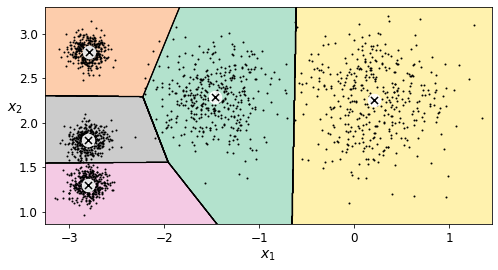

In [61]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Buscando el número óptimo de clusters

Hemos establecido el número de clusters en 5 pero, ¿quién nos asegura que sea el mejor número? Para ello, podemos utilizar un par de técnicas: una gráfica y otra matemática.

Pero antes de eso, vamos a empezar probando diferentes números de clusters, como 3 y 8, para ver si se ajustan mejor:

Saving figure bad_n_clusters_plot


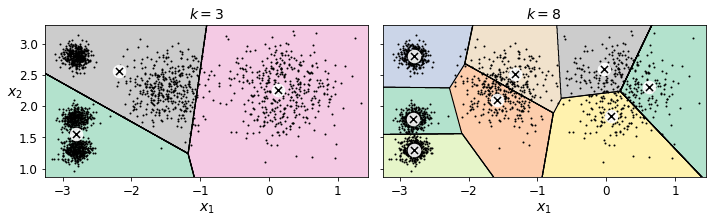

In [62]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Pues ninguno de los dos parece que se ajuste demasiado bien. Veamos qué nos dicen sus inertias:

In [63]:
kmeans_k3.inertia_

653.2223267580945

In [64]:
kmeans_k8.inertia_

118.44108623570084

Como podemos ver, la inertia del KMeans de 8 clusters es mucho más baja que la mejor que habíamos conseguido para ``k=5``. Sin embargo nos ería justo decir que fuese mejor el de 8, de hecho, podemos comprobar a simple vista que no es una buena aproximación.

Por lo tanto, no podemos coger aquel número de ``k`` que minimice la inertia, ya que a medida que vayamos aumentando el ``k``, la inertia se irá reduciendo. De hecho, cuantos más clusters haya, más cerca estará cada punto de su centroide más cercano y, por lo tanto, menor será la inercia. Sin embargo, podemos trazar la inercia en función de ``k`` y analizar la curva resultante:

In [65]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


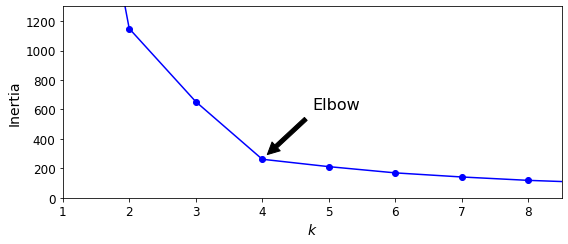

In [66]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

Como puedes ver, hay un codo (pasa a descender linealmente a partir de ahí) en ``k=4``, lo que significa que menos clústeres que eso sería malo, y más clústeres no ayudarían mucho y podrían cortar clústeres por la mitad. Así que ``k=4`` es una buena opción. Por supuesto, en este ejemplo no es perfecto, ya que significa que los dos blobs en la parte inferior izquierda se considerarán como un solo clúster, pero es una agrupación en clústeres bastante buena.

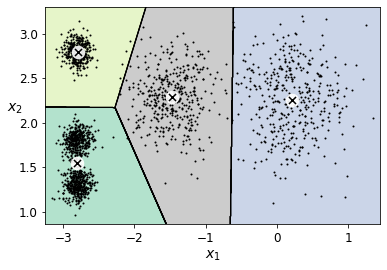

In [121]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Otra aproximación sería calcular la métrica _silhouette score_, que es la media del _coeficiente silhouette_, sobre todos los puntos. Una instancia del _coeficiente silhouette_ es igual a $(b - a)/\max(a, b)$ donde $a$ es a distancia media para el resto de puntos del mismo cluster (sería como la media intracluster), y $b$ es la _distancia media de cluster-cercano_, que es la media de la distancia de los puntos del cluster más cercano. El _coeficiente silhouette_ puede variar entre -1 y +1, donde su proximidad a +1 indica que el pupnto está muy dentro de su propio clúster y lejos de otros clústeres, mientras que un coeficiente cercano a 0 significa que está cerca de un límite de clúster y, finalmente, un coeficiente cercano a -1 significa que la instancia puede haberse asignado al clúster incorrecto

Vamos a pintar el silouette score en función de $k$:

In [67]:
from sklearn.metrics import silhouette_score

In [68]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [69]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [70]:
silhouette_scores

[0.5966442557582528,
 0.5723900247411775,
 0.6885316175957589,
 0.655517642572828,
 0.601878677912387,
 0.6068660656395705,
 0.5616085743054687,
 0.567647042788722]

Saving figure silhouette_score_vs_k_plot


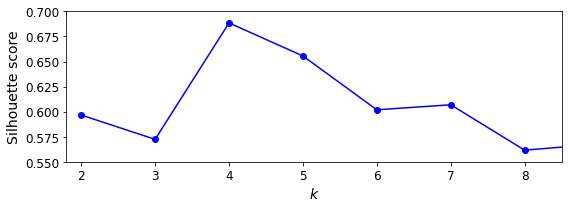

In [71]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Como puedes ver, esta visualización es mucho más rica que la anterior: en concreto, aunque confirme que $k=4$ es una muy buena opción, también destaca que $k=5$ es una buena combinación también.

A continuación, se ofrece una visualización aún más informativa al trazar el coeficiente de silueta de cada instancia, ordenado por el clúster al que están asignados y por el valor del coeficiente. Esto se denomina _silhouette diagram_:

Saving figure silhouette_analysis_plot


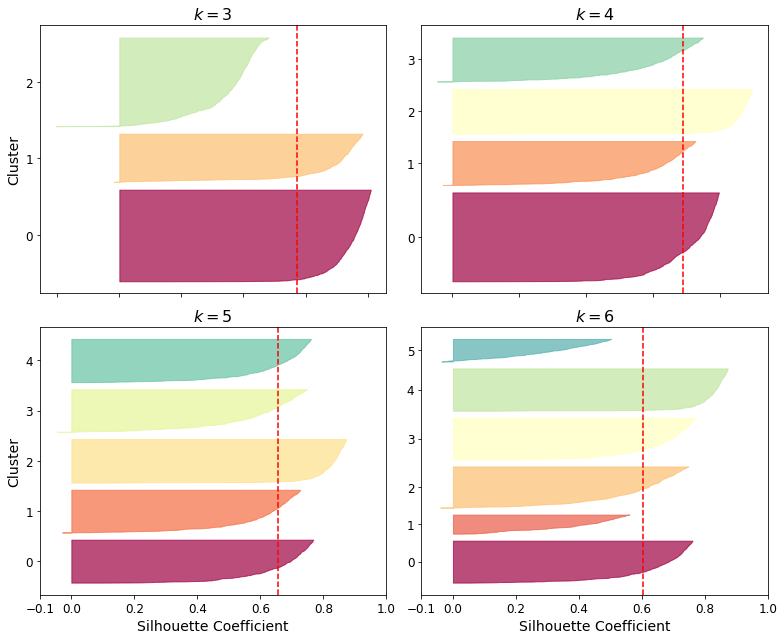

In [72]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

### Límites del K-Means

El algoritmo KMeans también tiene sus limitaciones:

* Es sensible a la inicialización aleatoria de los centroides
* Sensible a outliers
* Hay que definir de antemano la cantidad de clusters que queremos
* Al basarse en distancias euclideas, podemos tener problemas si no tenemos los datos normalizados o cuando crezca mucho las dimensiones de nuestro problema

Veamos un ejemplo donde se pone de manifiesto la importancia de los puntos iniciales:

In [73]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

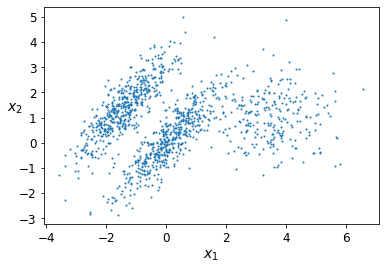

In [74]:
plot_clusters(X)

In [75]:
kmeans_good = KMeans(n_clusters = 3, init = np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init = 1, random_state = 42)
kmeans_bad = KMeans(n_clusters = 3, random_state = 42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


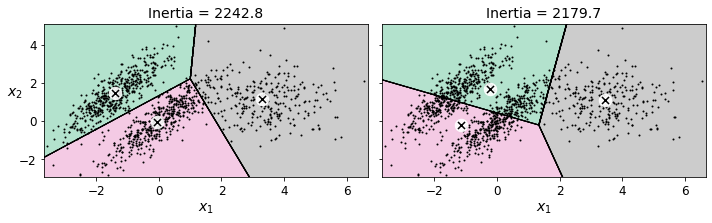

In [77]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

### EJERCICIO:

Prueba el algoritmo de clustering que acabamos de ver sobre el dataset del Titanic:
1. Prueba a predecir si una persona sobrevive o no
2. Prueba a utilizarlo para ver si una persona es hombre o mujer
3. Comprueba cuál es el mejor ``k`` en cada caso

In [78]:
import pandas as pd
df = pd.read_csv("../../data/titanic.csv", sep='\t')
df
# El que queda de Embarked, lo vamos a rellenar con "S" porque es el mayoritario.
df['Embarked'] = df['Embarked'].fillna('S')
# En Age, vamos a completar los valores nulos con la media de los valores de Age.
df['Age'] = df['Age'].fillna(df['Age'].mean())
# En Pclass, vamos a convertirlo a string para luego hacer el One Hot Encoding.
df['Pclass'] = df['Pclass'].astype(str)
# Separamos las variables que podemos utilizar para predecir de la que queremos predecir:
y_col = 'Survived'
X_cols = [col for col in df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]
X = df[X_cols]
y = df[y_col]
# Tratamiento categóricas:
X = pd.get_dummies(X)

## DBSCAN

Otro algoritmo de clustering interesante es el DBSCAN, que combate algunos de los problemas del KMeans. Como ya hemos comentado, funcionamiento es el siguiente:

* Definimos epsilon (distancia desde un punto para considerarlo vecino) y minPoints (número mínimo de vecinos para considerar a un punto como núcleo)
* Buscamos todos los vecinos para todos los puntos y los puntos que tengan más vecinos que minPoints lo marcamos como núcleo.
* Cada punto núcleo y todos sus vecinos lo asignamos a un cluster, si no está asignado previamente a ninguno. Recursivamente vamos añadiendo a sus vecinos núcleo.

Si bien es cierto que con esto el DBSCAN evita ciertos problemas del KMeans, como la selecciónd e un ``k`` inicial, también tiene algunos contras, como su sensibilidad a la inicialización del **epsilon** y los **minPoints**.


A continuación, se muestra un ejemplo con unos datos de muestra:

In [92]:
from sklearn.datasets import make_moons

In [93]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [94]:
from sklearn.cluster import DBSCAN

Seleccionamos el valor de epsilon (para trazar los círculos y coger los puntos cercanos) y el min_samples (el mínimo de puntos para considerarlo núcleo):

In [95]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [115]:
# Predicciones para cada punto sobre el que se ha entrenado:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [120]:
# Índices de los puntos que se han utilizado como puntos core (que cumplen la condición de tener el número mínimo de vecinos)
dbscan.core_sample_indices_

array([  0,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,
        32,  33,  34,  36,  38,  39,  41,  42,  44,  45,  47,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  59,  61,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  83,  84,  85,  87,  88,  89,  90,  91,  93,  94,  96,
        97,  98, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 114,
       115, 116, 117, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 135, 136, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149,
       150, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178,
       179, 181, 182, 183, 185, 186, 187, 188, 189, 191, 193, 194, 195,
       196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 22

In [121]:
len(dbscan.core_sample_indices_)

808

In [123]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [125]:
# Posiciones de los puntos que se han utilizado como puntos core (que cumplen la condición de tener el número mínimo de vecinos)
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

In [126]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

Como puedes observar, hay labels ``-1``, lo que identifica los puntos que se quedan sin asigar.

Vamos a crear otro modelo DBSCAN con mayor épsilon y compararemos ambos modelos:

In [127]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [128]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


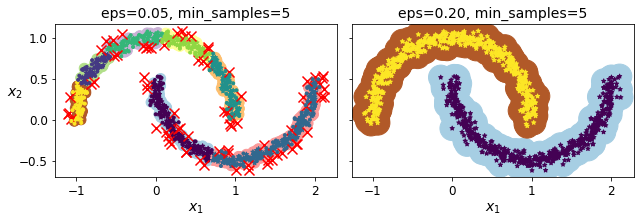

In [129]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


### EJERCICIO

Utiliza el siguiente dataset (sin Platform) para agrupar los registros con un DBSCAN a ver si nos da algo parecido al Platform. ¿Qué ``k`` ha sacado el DBSCAN?

Prueba a cambiar los parámetros a ver si consigues mejorar los resultados.

Finalmente, impleméntalo con un K-Means a ver si consigues un resultado mejor. En este caso, como estamos utilizando un dataset supervisado, podemos comprobar su desempeño en base a los datos. Sin embargo, en un algoritmo de clustering real, esto no será posible. Prueba a clasificarlos en base al inertia score que hemos visto para el K-Means y basándote en la columna ``Platform``, como si de un algoritmo supervisado se tratase:

In [130]:
import pandas as pd

df = pd.read_csv("../../data/vgsales.csv")

def get_platform(x):
    if x in ['DS', 'Wii', 'GBA', 'GC', '3DS', 'N64']:
        return 'Nintendo'
    elif x in ['PS2', 'PS3', 'PS', 'PSP', 'PS4', 'PSV', 'SNES']:
        return 'Sony'
    elif x in ['X360', 'PC', 'XB', 'XOne']:
        return 'Microsoft'
    else:
        return ''
    
df['Platform'] = df['Platform'].apply(lambda x: get_platform(x))

df = df[df['Platform'] != '']
df = df[df['Publisher'].isin(df['Publisher'].value_counts()[:20].index)]

df.dropna(subset=['Year'], inplace=True)

X_cols = ['Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
y_col = 'Platform'

X = pd.get_dummies(df[X_cols])
y = df[y_col]